In [1]:
## These are some essential Python packages for data science tasks. 
## They are widely used in various scripts because their combination allows to perform a powerful series of operations on data.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import time
import math
import warnings
warnings.filterwarnings('ignore')

## There are packages related to working with geospatial data and performing spatial analysis. 
## They allow you to represent and manipulate geographical features and data

#import geopandas as gpd
import shapely
from shapely.geometry import LineString, Point, MultiLineString, Polygon, MultiPoint
from shapely.ops import linemerge, nearest_points, unary_union, split, substring, voronoi_diagram
from shapely import minimum_rotated_rectangle, unary_union
from scipy.spatial import Voronoi, cKDTree
import networkx as nx
from scipy.optimize import Bounds, differential_evolution

import tkinter as tk
from tkinter import filedialog, messagebox

In [2]:
from hybrids import *
from dist_funcs import *

In [3]:
target_crs = 'EPSG:32615' ### For Guatemala

In [4]:
messagebox.showinfo('OnSSET-MG', 'Select the clusters')
clusters = gpd.read_file(filedialog.askopenfilename(filetypes = (("vector",["*.shp", "*.gpkg", "*.geojson"]),("all files","*.*")))).to_crs(target_crs)

In [5]:
messagebox.showinfo('OnSSET-MG', 'Select the buildings layer')
buildings = gpd.read_file(filedialog.askopenfilename(filetypes = (("vector",["*.shp", "*.gpkg", "*.geojson"]),("all files","*.*")))).to_crs(target_crs)
buildings_centroids = buildings.copy()
buildings_centroids["geometry"] = buildings_centroids["geometry"].centroid

In [6]:
messagebox.showinfo('OnSSET-MG', 'Select the folder where results will be stored')
workspace = filedialog.askdirectory()

In [7]:
country = "Guatemala"

Cluster 1 sucessfully proccessed
Cluster 2 sucessfully proccessed
Cluster 3 sucessfully proccessed
Cluster 4 sucessfully proccessed
Cluster 5 sucessfully proccessed
Cluster 6 sucessfully proccessed
Cluster 7 sucessfully proccessed
Cluster 8 sucessfully proccessed
Cluster 9 sucessfully proccessed
Cluster 10 sucessfully proccessed


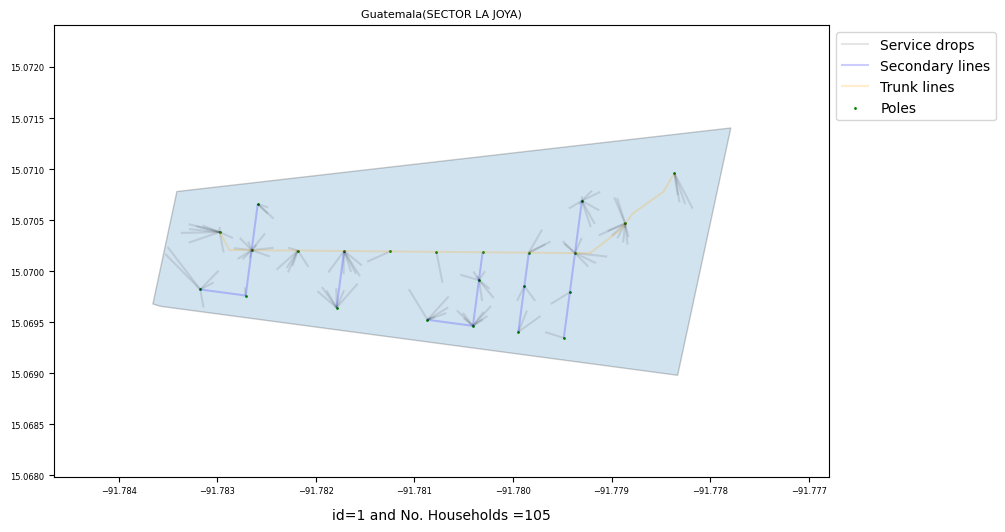

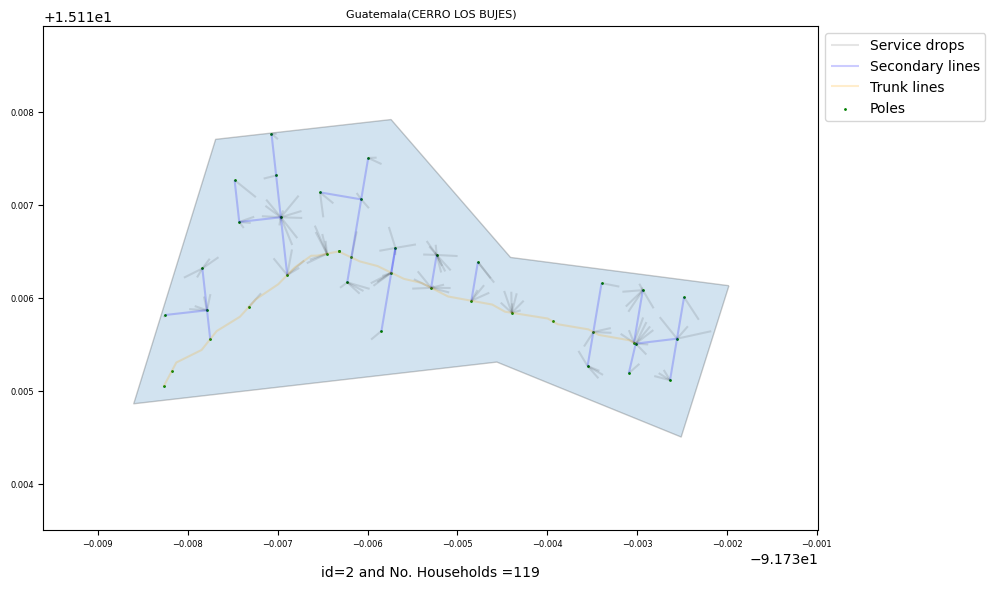

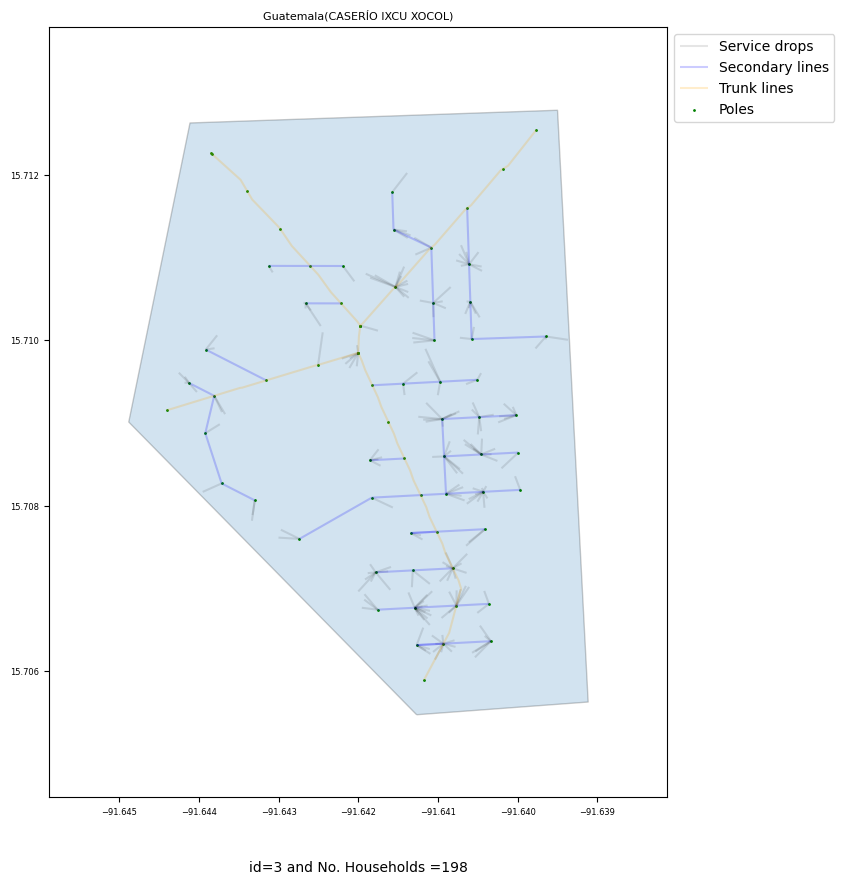

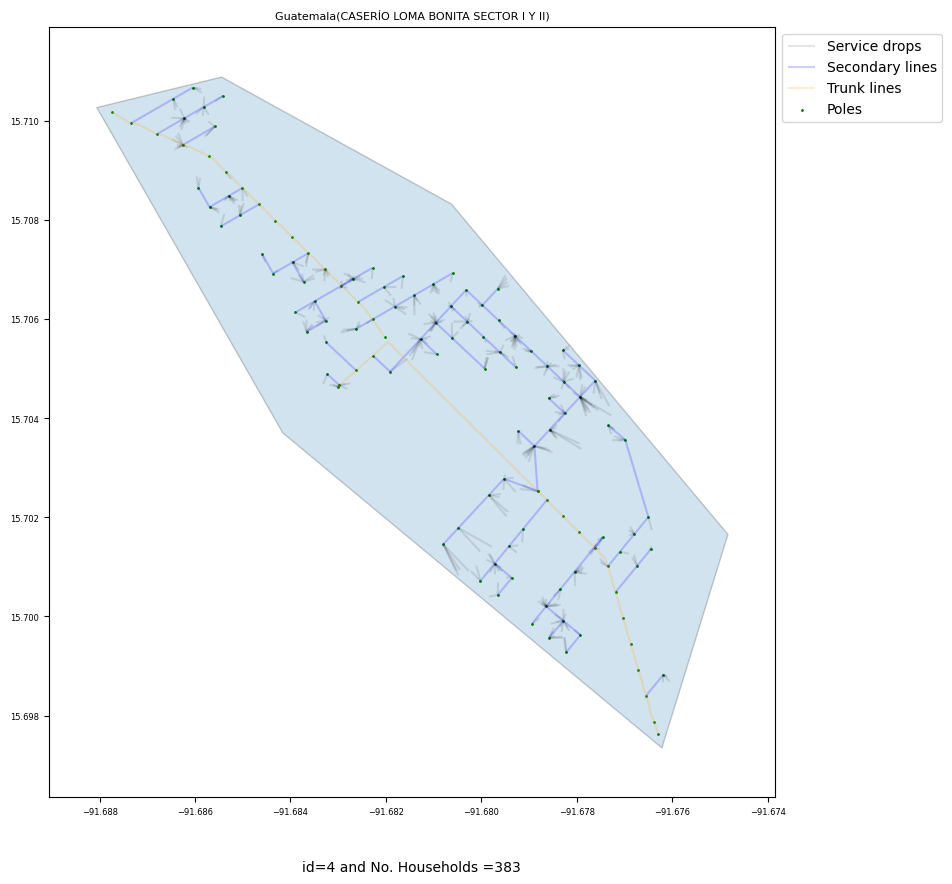

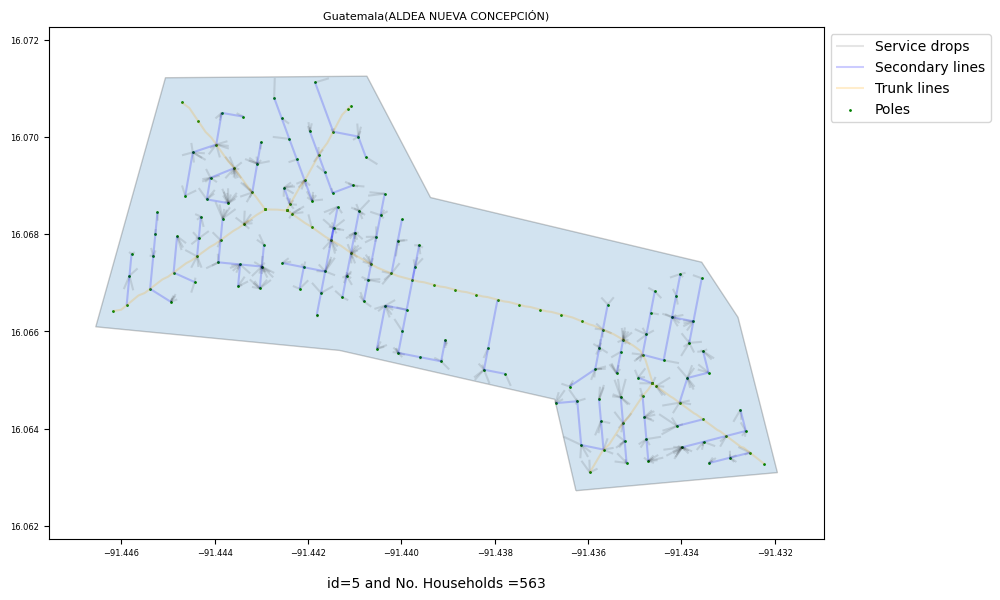

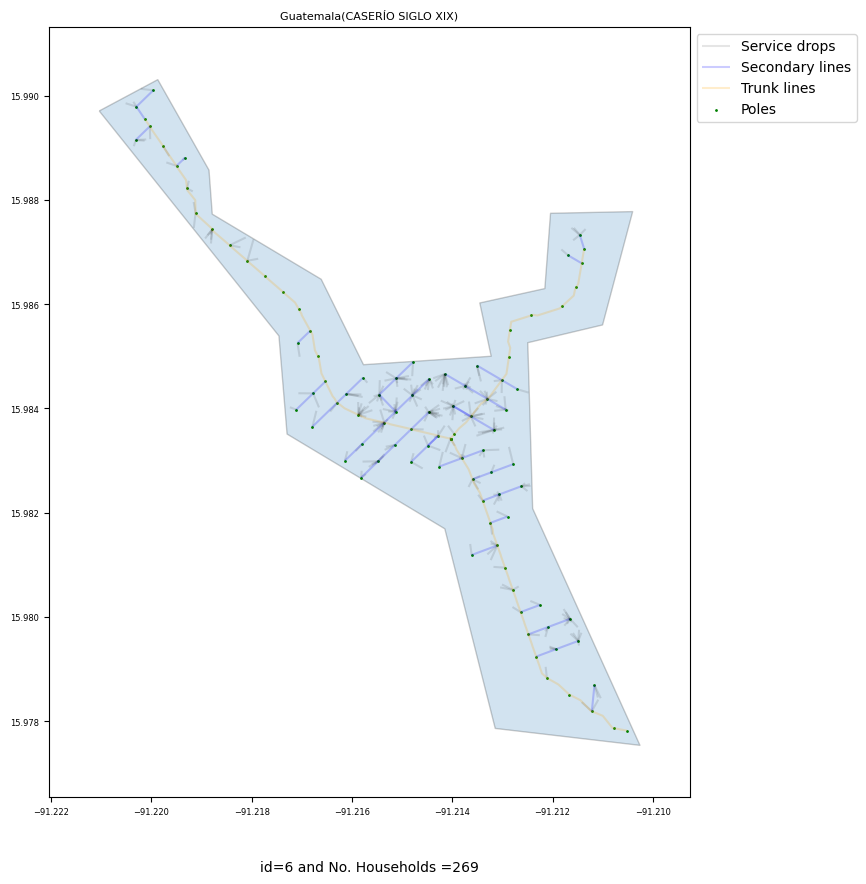

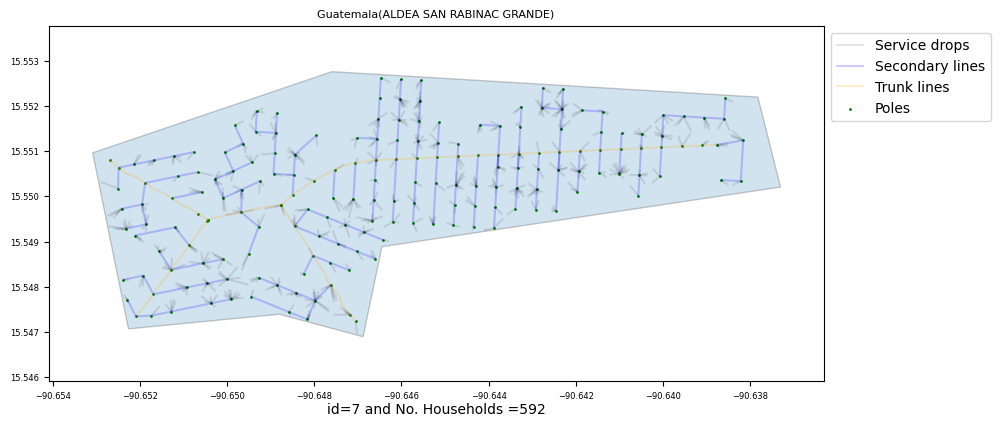

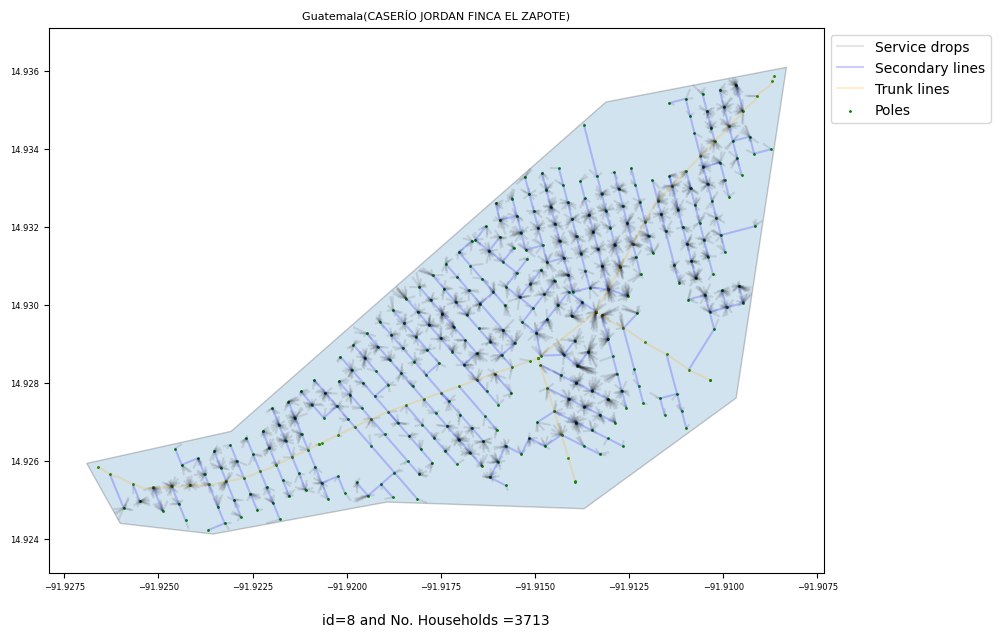

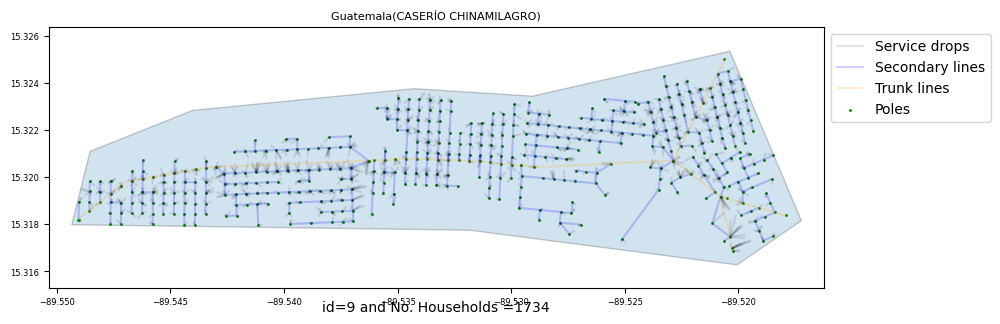

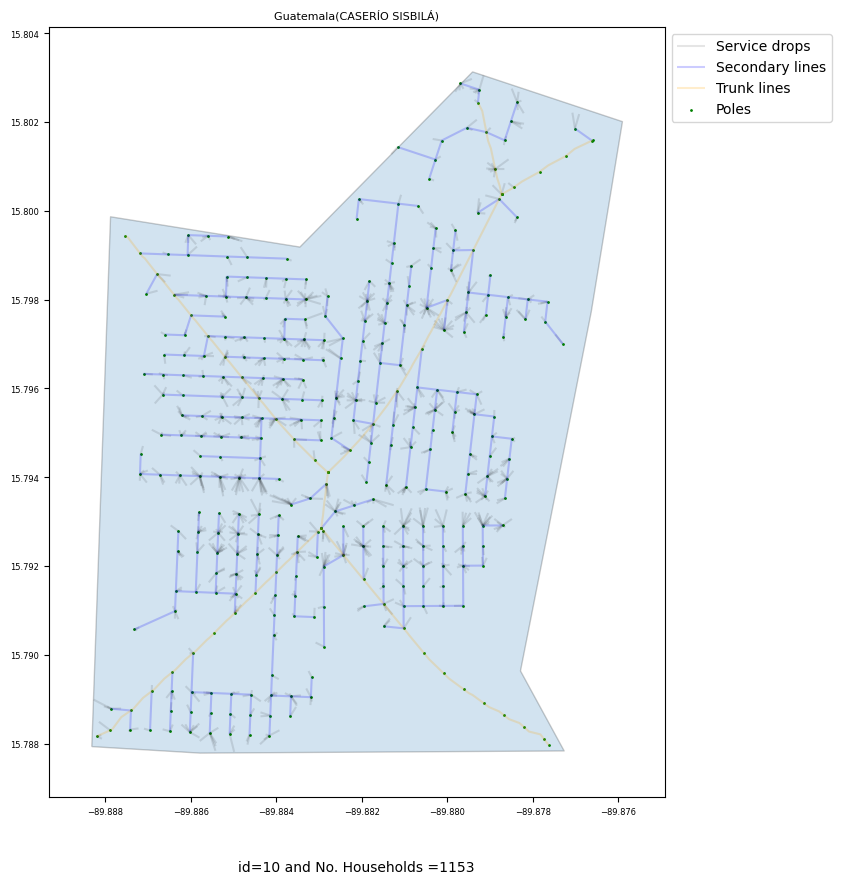

In [8]:
error_log = []

for id, row in clusters.iterrows():
    polygon=row.geometry
    gpd_mg =gpd.GeoDataFrame(geometry=[polygon], crs=target_crs)
    clipped_centroids = gpd.clip(gpd_mg, buildings_centroids)
    clipped_centroids =clipped_centroids.explode(index_parts=False)
    clip_footprints = gpd.clip(gpd_mg, buildings)

    try:
        
        trunk_lines = create_trunk_line(polygon, spacing=50, plot=False)
        
        # Simplify the trunk line(s)
        trunk_lines, intersects = simplify_trunk_lines(trunk_lines, length_removal=200, split_distance=750, plot=False)
        
        trunk_lines_gdf = gpd.GeoDataFrame(geometry=trunk_lines)
        
        voronois = voronoi_areas(trunk_lines_gdf, polygon, plot=False)
        
        grid, poles, service_gdf, secondary_gdf, trunks_gdf= creating_grid(trunk_lines, voronois, row.id, clipped_centroids, target_crs)

        community= row.COMUNIDAD
        id=row.id

        #Save as JPEG
        fig = plotting_jpeg(country, community, id, len(clipped_centroids), gpd_mg, service_gdf, secondary_gdf, trunks_gdf, poles, clip_footprints)

        # Construct the file name using string formatting
        filename = country+"_id={}.png".format(row.id)
        
        # Combine the directory and filename to create the full file path
        file_path = os.path.join(workspace, filename)
                
        fig.savefig(file_path, dpi=300, bbox_inches='tight')  

        print(f"Cluster {id} sucessfully proccessed")
            
    except Exception as e:
        # Log the error with details
        error_info = {
            'index': row.id,
            'error': str(e)
        }
        error_log.append(error_info)
        print(f"Error processing DataFrame {id}: {e}")

    